<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/mlc_2324_w5_cv_grid_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Cross Validation and Grid Search

* Machine Learning Concepts (MLC)
* Week 5, 2023/24
* Luciano Gerber

## Preamble: Importing and Configuring Essential Packages


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
if 'google.colab' in sys.modules:
    !pip install -q dtreeviz
import dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00


## Use Case: Diabetes (PIMA) Dataset

In [ ]:
dbt = pd.read_csv('https://raw.githubusercontent.com/gerberl/6G7V0015-2324/main/datasets/diabetes.csv')

In [ ]:
dbt.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1


## Pre-Processing

In [ ]:
# just to get things going, a broad-swipe-fillna
# dbt['Glucose':'Age'] = dbt['Glucose':'Age'].fillna(dbt['Glucose':'Age'].mean())
dbt_glc_age = dbt.loc[:, 'Glucose':'Age']
dbt.loc[:, 'Glucose':'Age'] = dbt_glc_age.replace(0, dbt_glc_age.mean())

In [ ]:
(dbt==0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [ ]:
X, y = dbt.drop(columns='Outcome'), dbt['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20231020)

## A First Decision Tree for Illustration

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
balanced_accuracy_score(y_test, dt.predict(X_test))

0.6924688627633571

In [ ]:
balanced_accuracy_score(y_train, dt.predict(X_train))

0.8207278035974981

<!-- ![5-Fold Cross Validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png) -->

[sklearn's documentation on cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html): many options (we'll discuss a couple in MLC/AML).

## Cross-Validation with K-Fold

<!-- ![K-Fold](https://github.com/gerberl/6G7V0015-2324/raw/main/figures/kfold_cv.png)

<img src="https://github.com/gerberl/6G7V0015-2324/raw/main/figures/kfold_cv.png" style="width:800px;height:600px;"/> -->

<img src="https://github.com/gerberl/6G7V0015-2324/raw/main/figures/kfold_cv.png" width="1600" height="200"/>



In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(dt, X, y, cv=5)

In [ ]:
scores

array([0.74025974, 0.68831169, 0.77272727, 0.79084967, 0.74509804])

In [ ]:
scores.mean(), scores.std()

(0.7474492827434004, 0.03486271249360156)

In [ ]:
scores = cross_val_score(dt, X, y, cv=10)
scores.mean(), scores.std()

(0.7200444292549555, 0.037477609129850806)

In [ ]:
# sns.lineplot(
    # data=fmri, x="timepoint", y="signal", hue="event", err_style="bars", errorbar=("se", 2),
# )

* **scores and **losses**:
    - score: the higher, the better. A "got-things-right" aggregate. Examples are balanced accuracy (classification) and explained variance ($R^2$) (regression).

    - loss: the lower, the better. A "got-things-wrong" aggregate. Examples are mean absolute error (regression)

## Hyper-Parameter Search with Grid Search

* https://scikit-learn.org/stable/modules/grid_search.html#grid-search
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [ 1, 3, 4, 8 ],
    'min_samples_leaf': [ 10, 20, 30]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = GridSearchCV(dt, param_grid, return_train_score=True)

In [ ]:
gs_results = clf.fit(X_train, y_train)

In [ ]:
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
gs_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [ ]:
gs_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003674,0.001677,0.002082,0.000313,1,10,"{'max_depth': 1, 'min_samples_leaf': 10}",0.732759,0.643478,0.765217,...,0.718726,0.040415,10,0.75,0.759219,0.72885,0.737527,0.739696,0.743059,0.010518


In [ ]:
gs_df[ ['param_max_depth', 'param_min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,param_max_depth,param_min_samples_leaf,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
6,4,10,0.803814,0.010784,0.767346,0.013014,1
8,4,30,0.795137,0.004105,0.765622,0.036072,2
11,8,30,0.799050,0.006935,0.765622,0.036072,2
7,4,20,0.801645,0.008952,0.762144,0.016235,4
10,8,20,0.816840,0.008537,0.758666,0.020287,5
9,8,10,0.844176,0.011300,0.753463,0.040682,6
5,3,30,0.773861,0.014848,0.741334,0.030674,7
4,3,20,0.773427,0.014730,0.739595,0.030502,8
3,3,10,0.771692,0.014768,0.739580,0.030634,9
0,1,10,0.743059,0.010518,0.718726,0.040415,10


## Other Resources

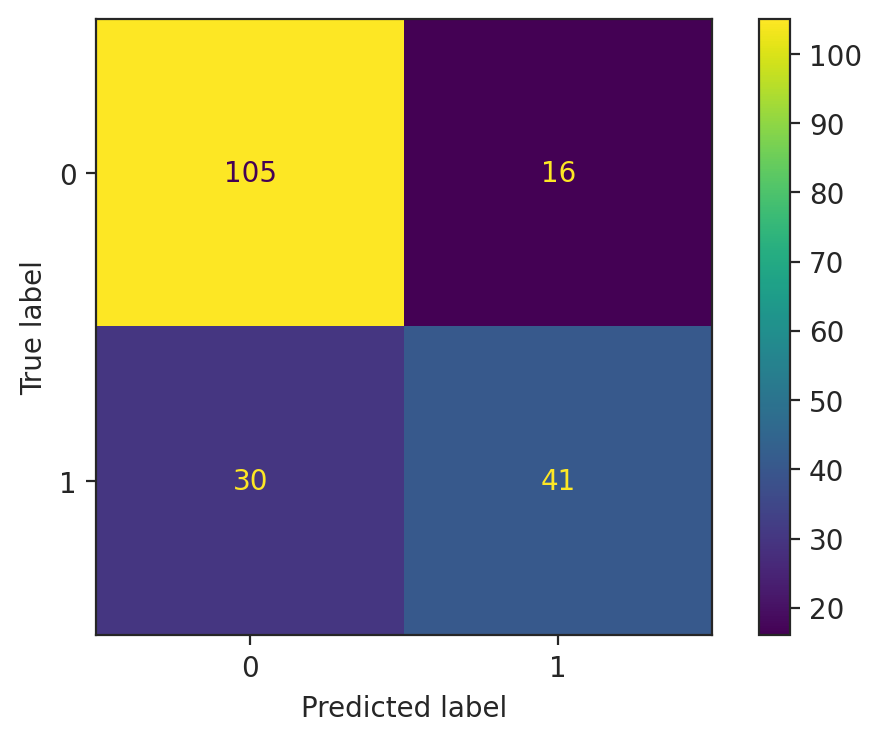

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, dt.predict(X_test))
).plot();

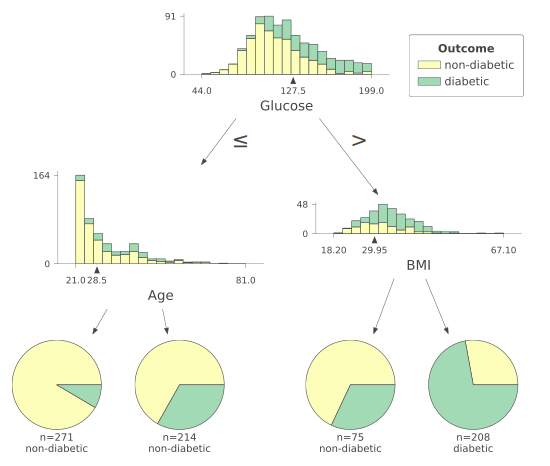

In [ ]:
dtviz = dtreeviz.model(
    dt, X, y, target_name='Outcome', feature_names=X.columns,
    class_names=["non-diabetic", "diabetic"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

In [ ]:
# print(
#     export_text(dt, feature_names=X.columns, class_names=["non-diabetic", "diabetic"])
# )
print(
    export_text(dt, feature_names=X.columns.to_list())
)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- class: 0
|   |--- BMI >  29.95
|   |   |--- class: 1



## Other Decision Tree Configurations

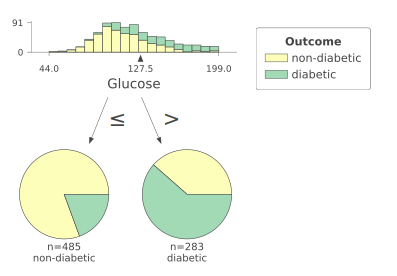

In [ ]:
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X_train, y_train)
dtviz = dtreeviz.model(
    dt1, X, y, target_name='Outcome', feature_names=X.columns,
    class_names=["non-diabetic", "diabetic"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

In [ ]:
balanced_accuracy_score(y_test, dt1.predict(X_test))

0.7223256896752415

In [ ]:
balanced_accuracy_score(y_train, dt1.predict(X_train))

0.7129367960033752

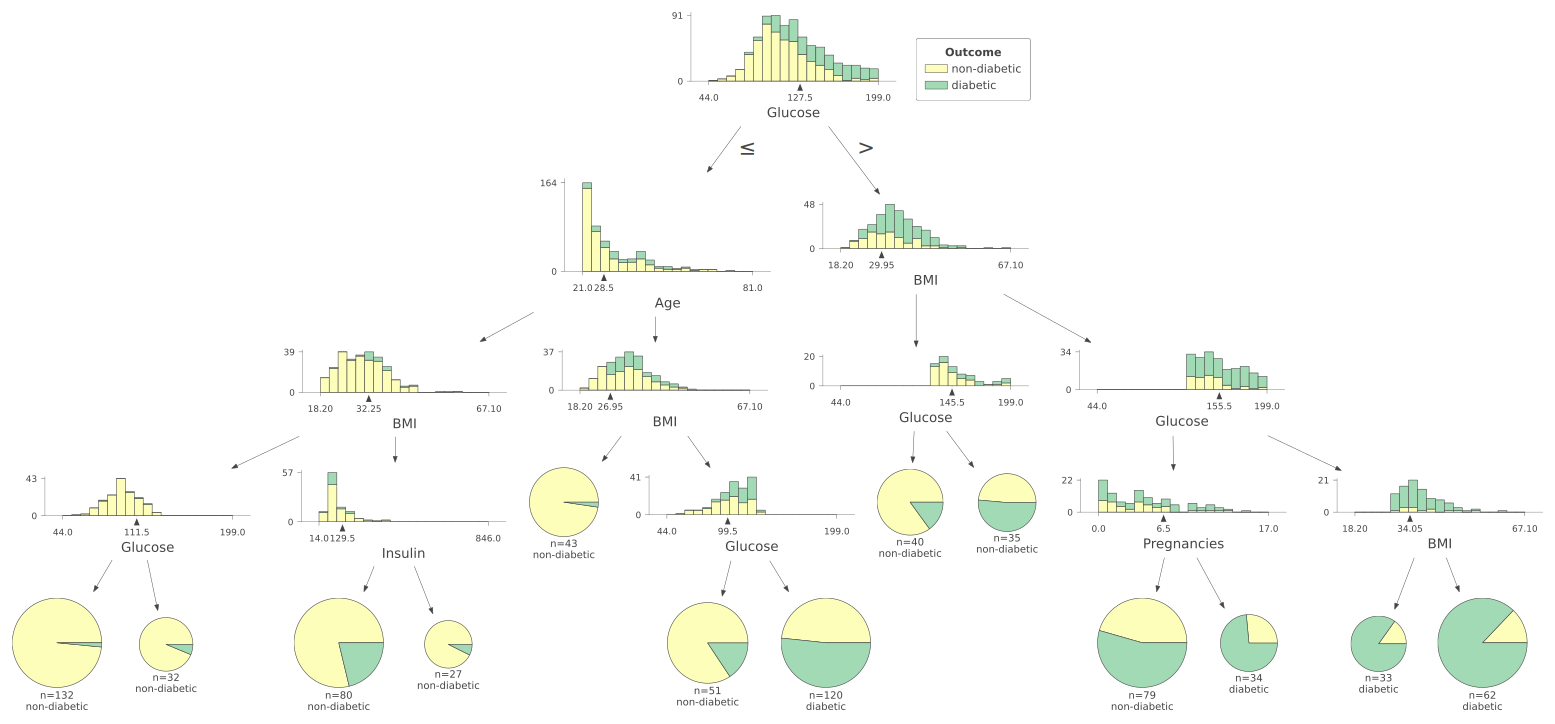

In [ ]:
dt4 = DecisionTreeClassifier(max_depth=4, min_samples_split=20, min_samples_leaf=20)
dt4.fit(X_train, y_train)
dtviz = dtreeviz.model(
    dt4, X, y, target_name='Outcome', feature_names=X.columns,
    class_names=["non-diabetic", "diabetic"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

In [ ]:
balanced_accuracy_score(y_test, dt4.predict(X_test))

0.6630776393900594

In [ ]:
balanced_accuracy_score(y_train, dt4.predict(X_train))

0.7600283942515034